## Import all required packages.

We decided to perform the random forest classification for classify pokemon legendary status.

In [41]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from tpot import TPOTClassifier

In [4]:
pokemon = pd.read_csv("Pokemon.csv")
print(pokemon.head())

   #                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  


## Data transformation before performing the model.

In order to perform the random forest classification, we need to encode string variables into integers. For doing so, we use the package called LabelEncoder to perform the certain transformation

In [7]:
for column in pokemon['Type 1']:
    if pokemon['Type 1'].dtype == type(object):
        le = LabelEncoder()
        pokemon['Type 1'] = le.fit_transform(pokemon['Type 1'])
        
pokemon = pokemon.replace(np.nan, 'No Type 2', regex=True)
        
for column in pokemon['Type 2']:
    if pokemon['Type 2'].dtype == type(object):
        le = LabelEncoder()
        pokemon['Type 2'] = le.fit_transform(pokemon['Type 2'])
        
print(pokemon.head())

   #                   Name  Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur       9      14    318  45      49       49   
1  2                Ivysaur       9      14    405  60      62       63   
2  3               Venusaur       9      14    525  80      82       83   
3  3  VenusaurMega Venusaur       9      14    625  80     100      123   
4  4             Charmander       6      12    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  


## Spliting Data

For performing the random forest classification, we firstly split data into training and testing data. Also, since the attribute 'Total' is the composition of all other ability scores, we decided to drop all other scores and keep 'Total' instead.

In [8]:
X=pokemon[['Type 1', 'Type 2','Total', 'Generation']]  # Features
y=pokemon['Legendary']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [36]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=250)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9541666666666667



After performing random forest classification, our accuracy of classification is 95%. 


            IMPORTANCE
FEATURE               
Total            0.697
Type 1           0.120
Generation       0.093
Type 2           0.089


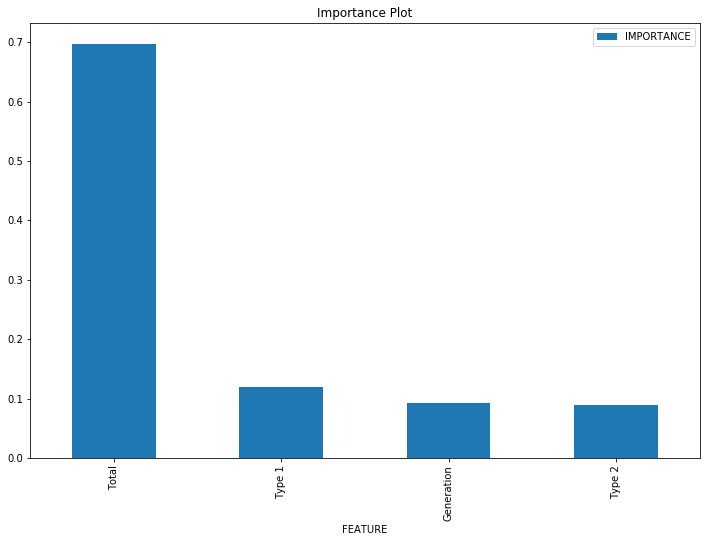

In [38]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
importances = pd.DataFrame({'FEATURE':X.columns,'IMPORTANCE':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

print(importances)
importances.plot.bar(figsize = (12,8), title = "Importance Plot")
plt.show()

We have also created a importance plot to visualize the importance of each variables. The importance of 'Total' is nearly 0.7 that beget it as the most important variable in this model. The rest of variables are not as important as 'Total'.

## Cross Validation

We also performed a 10-fold cross validation for checking the overfitting.

In [50]:
# Perform a 10-fold cross validation
print (np.mean(cross_val_score(clf, X_train, y_train, cv=10)))

0.9590806561859194


The result of the cross validation absolve the issue of overfitting. We conclude that our model is valid.

## Pipeline optimization

For enhancing our model, we decided to use the method TPOT classifier from package TPOT. The function will create numerous pipelines and keep compositing different models until your designated termination. Then the function will return a final composite model to us with a optimized accuracy.

In [51]:
# Use package TPOT to perform a pipeline_optimizer in order to enchance the model
pipeline_optimizer = TPOTClassifier()
pipeline_optimizer = TPOTClassifier(generations=10, population_size=80, cv=5,n_jobs=-1,
                                    random_state=31415, verbosity=2)

In [52]:
pipeline_optimizer.fit(X_train, y_train)

A Jupyter Widget

Generation 1 - Current best internal CV score: 0.9679347330896002
Generation 2 - Current best internal CV score: 0.9679347330896002
Generation 3 - Current best internal CV score: 0.9679347330896002
Generation 4 - Current best internal CV score: 0.9679508206056878
Generation 5 - Current best internal CV score: 0.9697529071422878
Generation 6 - Current best internal CV score: 0.9697529071422878
Generation 7 - Current best internal CV score: 0.9697687099235772
Generation 8 - Current best internal CV score: 0.9715544242092914
Generation 9 - Current best internal CV score: 0.9715544242092914
Generation 10 - Current best internal CV score: 0.9715544242092914

Best pipeline: DecisionTreeClassifier(KNeighborsClassifier(BernoulliNB(input_matrix, alpha=0.001, fit_prior=False), n_neighbors=12, p=1, weights=uniform), criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=12)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=10,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=80,
        random_state=31415, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [54]:
print(pipeline_optimizer.score(X_test, y_test))

0.95


The final model also gives an accuracy around 95%.

## Conclusion:
After performing the TPOT classification, we can see the accuracy did not enchance through our new composite model. We suspect that the reason behind this problem is our data consists inbalanced legendary status. Our testing data consists 240 observations, but only 22 of them are legendary. Due to the restriction of insufficient data recorded, we could not enlarge the amount of legendary pokemons. Our model is best performed with this extreme inbalanced dataset. 

## Limitation: 
- As mentioned above, one of the limitation of our study is the insufficient observations of legendary pokemons. 
- Besides the insufficient legendary pokemons, we also need more observations for both legendary and non-legendary pokemons for performing a better result of random forest classification. 
- we might need more essential variables in this dataset, such as species strength.
- As mentioned in the background, the dataset includes both original status and evolved status of each pokemon. Pokemon's ability will enhance significantly by evolution. Therefore, it seems like the dataset included some unuseful information for classification since unevolved pokemons tend to have low ability scores.
- We also suspect that the random forest might not be the best model for this type of classification.